In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from datasets import load_dataset
from torchinfo import summary
import tensorboard

c:\Users\souss\Document\realtime-sentiment-analysis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


In [4]:
sns.set_style("whitegrid")

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\souss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:

stop_words = set(stopwords.words('english'))
type(stop_words)

set

In [7]:
class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    SENTIMENT_THRESHOLDS = (0.4, 0.7)
class Config:
    """
    Classe statique de configuration pour le modèle de classification des tweets.
    """
    # Paramètres de données
    DATA_PATH = "../DATA/train.csv"  
    SAVE_DATA_PATH = "../DATA/train_cleaned.csv" 
    MAX_SEQ_LEN = 512              # Longueur maximale des séquences
    

    # Paramètres de prétraitement
    REMOVE_STOPWORDS = True         # Indiquer si on enlève les stopwords
    LOWERCASE = True                # Mettre tout en minuscules

    # Modele ModernBert
    MODEL_ID = "answerdotai/ModernBERT-base"

    # Paramètres d'entraînement
    OUTPUT_DIR = "./training_dir"    # Répertoire de sauvegarde des modèles
    BATCH_SIZE = 32                 # Taille des batchs
    EPOCHS = 10                     # Nombre d'époques
    LEARNING_RATE = 1e-3            # Taux d'apprentissage
    OPTIMIZER = "adamw_torch_fused"              # Optimiseur
    REPORT_TO  = "tensorboard"      # Rapport pour tensorboard
    BF16 = True                   # Utiliser le format BF16
    NUM_TRAIN_EPOCHS = 3            # Nombre d'époques d'entraînement
    EVAL_STRATEGY = "epoch"         # Stratégie d'évaluation
    SAVE_STRATEGY = "epoch"         # Stratégie de sauvegarde
    
    

    # Paramètres de sauvegarde
    MODEL_SAVE_PATH = "./models/tweet_classifier.pt"  # Chemin pour sauvegarder le modèle
    LOG_DIR = "./logs"                                # Répertoire des logs

    # Utilisation de GPU
    USE_CUDA = True               

    @staticmethod
    def display():
        """
        Affiche les paramètres de configuration.
        """
        for attr in dir(Config):
            if not attr.startswith("__") and not callable(getattr(Config, attr)):
                print(f"{attr}: {getattr(Config, attr)}")


# Exemple d'utilisation
Config.display()


BATCH_SIZE: 32
BF16: True
DATA_PATH: ../DATA/train.csv
EPOCHS: 10
EVAL_STRATEGY: epoch
LEARNING_RATE: 0.001
LOG_DIR: ./logs
LOWERCASE: True
MAX_SEQ_LEN: 512
MODEL_ID: answerdotai/ModernBERT-base
MODEL_SAVE_PATH: ./models/tweet_classifier.pt
NUM_TRAIN_EPOCHS: 3
OPTIMIZER: adamw_torch_fused
OUTPUT_DIR: ./training_dir
REMOVE_STOPWORDS: True
REPORT_TO: tensorboard
SAVE_DATA_PATH: ../DATA/train_cleaned.csv
SAVE_STRATEGY: epoch
USE_CUDA: True


In [8]:
if Config.USE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")


In [8]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [9]:
classifier('We are very happy to show you the 🤗 Transformers library.')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [10]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [11]:
df  = pd.read_csv(Config.DATA_PATH)
df.head()

,text,target
0,Disnleyland ISN'T tha happiest place in tha wo...,4
1,OMG BELLLLYYY SHOUTIN AT SUM FOOD.. BRB SOOOO ...,0
2,I'm still waiting to find out what #caca stand...,0
3,So's your face,4
4,So sad to see her drive away wat do i do now??,0


In [12]:
df.target = df.target.map({0:Sentiment.NEGATIVE, 2:Sentiment.NEUTRAL, 4:Sentiment.POSITIVE})
df.head()

,text,target
0,Disnleyland ISN'T tha happiest place in tha wo...,POSITIVE
1,OMG BELLLLYYY SHOUTIN AT SUM FOOD.. BRB SOOOO ...,NEGATIVE
2,I'm still waiting to find out what #caca stand...,NEGATIVE
3,So's your face,POSITIVE
4,So sad to see her drive away wat do i do now??,NEGATIVE


In [13]:
df.shape

(1120000, 2)

In [14]:
df.isna().sum()

text      0
target    0
dtype: int64

In [15]:
df.duplicated().sum()

np.int64(9812)

In [16]:
df = df.drop_duplicates()
df.shape

(1110188, 2)

<Axes: xlabel='target'>

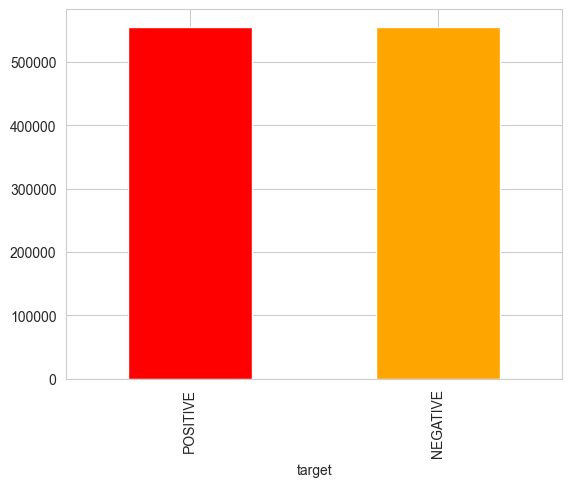

In [17]:
df.target.value_counts().plot(kind="bar", color=["red", "orange", "green"])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.002, random_state=42)

In [42]:
prob_preds = classifier(X_test.values.tolist())

In [ ]:
prob_preds

In [50]:
pred_score = [pred['score'] if pred['label'].startswith('P') else 1-pred['score']  for pred in prob_preds ]
pred_sentiment = [pred['label'] for pred in prob_preds]

In [9]:
def get_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = Sentiment.NEUTRAL
        if score <= Sentiment.SENTIMENT_THRESHOLDS[0]:
            label = Sentiment.NEGATIVE
        elif score >= Sentiment.SENTIMENT_THRESHOLDS[1]:
            label = Sentiment.POSITIVE

        return label
    else:
        return Sentiment.NEGATIVE if score < 0.5 else Sentiment.POSITIVE

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)# remove urls
    tweet = re.sub(r'\@\w+|\#', '', tweet) # remove mentions and hashtags
    tweet = re.sub(r'\d+', '', tweet) # remove numbers
    tweet = re.sub(r'<.*?>', '', tweet) # remove html tags
    tweet = re.sub(r'[^\w\s]', '', tweet) # remove punctuation
    tweet = re.sub(r'\s+', ' ', tweet) # remove extra spaces
    tweet = tweet.strip() # remove leading and trailing white spaces
    return tweet

def process_tweet(tweet):
    tweet = clean_tweet(tweet)
    tokens = tweet.split()
    if Config.REMOVE_STOPWORDS:
        tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [10]:
np.sum(y_test.values == pred_sentiment)/len(y_test)

NameError: name 'y_test' is not defined

In [ ]:
cm = confusion_matrix(y_test, pred_sentiment, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE, Sentiment.NEUTRAL])
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE, Sentiment.NEUTRAL])
disp.plot()

In [ ]:
print(classification_report(y_test, pred_sentiment, target_names=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))

In [20]:
df["text_process"] = df.text.apply(process_tweet)
df.head()

,text,target,text_process
0,Disnleyland ISN'T tha happiest place in tha wo...,POSITIVE,disnleyland isnt tha happiest place tha world ...
1,OMG BELLLLYYY SHOUTIN AT SUM FOOD.. BRB SOOOO ...,NEGATIVE,omg bellllyyy shoutin sum food brb soooo starv...
2,I'm still waiting to find out what #caca stand...,NEGATIVE,im still waiting find caca stands hoping think...
3,So's your face,POSITIVE,sos face
4,So sad to see her drive away wat do i do now??,NEGATIVE,sad see drive away wat


In [21]:
df.drop(columns=["text"], inplace=True)
df.head()

,target,text_process
0,POSITIVE,disnleyland isnt tha happiest place tha world ...
1,NEGATIVE,omg bellllyyy shoutin sum food brb soooo starv...
2,NEGATIVE,im still waiting find caca stands hoping think...
3,POSITIVE,sos face
4,NEGATIVE,sad see drive away wat


In [22]:
df.columns  = ['labels', "sentence"]
df.head()

,labels,sentence
0,POSITIVE,disnleyland isnt tha happiest place tha world ...
1,NEGATIVE,omg bellllyyy shoutin sum food brb soooo starv...
2,NEGATIVE,im still waiting find caca stands hoping think...
3,POSITIVE,sos face
4,NEGATIVE,sad see drive away wat


In [23]:
df.dtypes

labels      object
sentence    object
dtype: object

In [24]:
df["sentence"] = df["sentence"].astype(str)
df["labels"] = df["labels"].astype(str)
df.dtypes

labels      object
sentence    object
dtype: object

In [42]:
(df.sentence=="").sum()

np.int64(4887)

In [43]:
df.sentence.replace("", np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(1105301, 2)

In [44]:
(df.sentence=="").sum()

np.int64(0)

In [45]:
df.to_csv(Config.SAVE_DATA_PATH, index=False)

In [11]:
data = load_dataset('csv', data_files=Config.SAVE_DATA_PATH)
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'sentence'],
        num_rows: 1105301
    })
})

In [12]:
train_test_data = data["train"].train_test_split(test_size=0.1, seed=42)
train_test_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'sentence'],
        num_rows: 994770
    })
    test: Dataset({
        features: ['labels', 'sentence'],
        num_rows: 110531
    })
})

In [13]:
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_ID)
tokenizer


PreTrainedTokenizerFast(name_or_path='answerdotai/ModernBERT-base', vocab_size=50280, model_max_length=8192, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("|||IP_ADDRESS|||", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	1: AddedToken("<|padding|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50254: AddedToken("                        ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50255: AddedToken("                       ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50256: AddedToken("                      ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50257: AddedToken("                    

In [14]:
tokenizer.model_max_length = Config.MAX_SEQ_LEN

In [15]:
test = tokenizer("We are very happy to show you the 🤗 Transformers library.")
test

{'input_ids': [50281, 1231, 403, 1077, 5211, 281, 921, 368, 253, 22692, 99, 234, 34717, 398, 6335, 15, 50282], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
def tokenize(batch):
    return tokenizer(batch["sentence"],padding="max_length", truncation=True, return_tensors="pt")

In [17]:
train_test_data["train"].column_names

['labels', 'sentence']

In [18]:
type(train_test_data["train"][0]["sentence"])

str

In [21]:
tokenized_dataset = train_test_data.map(tokenize, batched=True, remove_columns=["sentence"])

Map: 100%|██████████| 994770/994770 [03:28<00:00, 4777.93 examples/s]


In [22]:
tokenized_dataset["train"].features.keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [32]:
tokenized_dataset["test"][1]

{'labels': 'NEGATIVE',
 'input_ids': [50281,
  1452,
  1578,
  36876,
  653,
  9289,
  2372,
  5075,
  50282,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,

In [24]:
labels = tokenized_dataset["train"].features["labels"]
labels

Value(dtype='string', id=None)

In [25]:
# Prepare model labels - useful for inference
labels = ["NEGATIVE","POSITIVE"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(Config.MODEL_ID, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
summary(model)

Layer (type:depth-idx)                                       Param #
ModernBertForSequenceClassification                          --
├─ModernBertModel: 1-1                                       --
│    └─ModernBertEmbeddings: 2-1                             --
│    │    └─Embedding: 3-1                                   38,682,624
│    │    └─LayerNorm: 3-2                                   768
│    │    └─Dropout: 3-3                                     --
│    └─ModuleList: 2-2                                       --
│    │    └─ModernBertEncoderLayer: 3-4                      5,014,272
│    │    └─ModernBertEncoderLayer: 3-5                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-6                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-7                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-8                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-9                      5,015,040
│    │    └─ModernBertEncoderLayer: 3-10        

In [28]:
training_args = TrainingArguments(
    output_dir=Config.OUTPUT_DIR,
    num_train_epochs=Config.EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    eval_strategy=Config.EVAL_STRATEGY,
    save_strategy=Config.SAVE_STRATEGY,
    optim=Config.OPTIMIZER,
    report_to=Config.REPORT_TO
)

In [29]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'recall': recall_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='macro'),
        'f1': f1_score(labels, predictions, average='macro')
    }


In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

In [31]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.